In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler

from sklearn.impute import KNNImputer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

In [18]:
RANDOM_STATE = 33
TEST_SIZE = 0.4
TARGET = 'Stay'

In [19]:
df_train= pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

In [20]:
# vars1 = [
#     'Hospital_region_code',
#     'Available Extra Rooms in Hospital',
#     'Department',
#     'Ward_Type',
#     'Ward_Facility_Code',
#     'Bed Grade',
#     'Type of Admission',
#     'Severity of Illness',
#     'Visitors with Patient',
#     'Age',
#     'Admission_Deposit',
# ]

vars1 = [
    # OHE features
    # 'Hospital_region_code',
    # 'Department',
    # 'Ward_Type',
    # 'Ward_Facility_Code',
    # 'Type of Admission',

    # ordinal features
    'Bed Grade',
    'Severity of Illness',
    'Admission_Deposit',
    # 'Stay'

    # numeric features
    'Visitors with Patient',
    'Age',
    'Admission_Deposit',
    'Available Extra Rooms in Hospital'
]


In [21]:
# onehot_features = [
#     'Hospital_region_code',
#     'Department',
#     'Ward_Type',
#     # 'Ward_Facility_Code',
#     # 'Type of Admission',
# ]

ordinal_features = [
    'Bed Grade',
    'Severity of Illness',
    # 'Stay'
]

numeric_features = [
    'Visitors with Patient',
    'Age',
    'Admission_Deposit',
    'Available Extra Rooms in Hospital'
]

In [22]:
vars1_with_target = vars1.copy()
vars1_with_target.append(TARGET)


df_train[vars1_with_target].head()

,Bed Grade,Severity of Illness,Admission_Deposit,Visitors with Patient,Age,Admission_Deposit,Available Extra Rooms in Hospital,Stay
0,2.0,Extreme,4911.0,2,51-60,4911.0,3,0-10
1,2.0,Extreme,5954.0,2,51-60,5954.0,2,41-50
2,2.0,Extreme,4745.0,2,51-60,4745.0,2,31-40
3,2.0,Extreme,7272.0,2,51-60,7272.0,2,41-50
4,2.0,Extreme,5558.0,2,51-60,5558.0,2,41-50


In [23]:
df_train_vars1 = df_train[vars1_with_target]
X_train_var1s = df_train[vars1]
y_train = df_train[['Stay']]

In [24]:
X_train_var1s.head()

,Bed Grade,Severity of Illness,Admission_Deposit,Visitors with Patient,Age,Admission_Deposit,Available Extra Rooms in Hospital
0,2.0,Extreme,4911.0,2,51-60,4911.0,3
1,2.0,Extreme,5954.0,2,51-60,5954.0,2
2,2.0,Extreme,4745.0,2,51-60,4745.0,2
3,2.0,Extreme,7272.0,2,51-60,7272.0,2
4,2.0,Extreme,5558.0,2,51-60,5558.0,2


In [25]:
y_train.head()

,Stay
0,0-10
1,41-50
2,31-40
3,41-50
4,41-50


In [26]:
onehot = OneHotEncoder()
y_train_1hot = onehot.fit_transform(y_train).toarray()

y_train_1hot.argmax(axis=1)

array([0, 4, 3, ..., 1, 1, 0], shape=(318438,))

In [27]:
def knn_validate(predictor, X, y, scoring_average, test_size = TEST_SIZE, random_state = RANDOM_STATE):

    X_train_, X_val_, y_train_, y_val_ = train_test_split(X, y, test_size=test_size, random_state=random_state)

    print("Valdiation split created")
    if isinstance(predictor, KNeighborsClassifier):
        if not scoring_average or scoring_average == 'binary':
            raise ValueError('Multiclass knn target requires non binary average')


    predictor.fit(X_train_, y_train_)
    print("Model fitted")

    print('Predicting...')
    y_pred = predictor.predict(X_val_)
    print(f"y_pred unique: {np.unique(y_pred)}")
    print(f"y_val unique: {np.unique(y_val_)}")

    # print(pd.crosstab(y_val_, y_pred))

    # this code sucks
    f1 = f1_score(y_val_, y_pred, average=scoring_average)
    accuracy = accuracy_score(y_val_, y_pred)
    recall = recall_score(y_val_, y_pred, average=scoring_average)
    preciscion = precision_score(y_val_, y_pred, average=scoring_average)

    # print(y_val_.argmax(axis=1))
    # print(y_pred.argmax(axis=1))


    # NOTE: confusion matrix will scale with size of input vectors
    # tn, fp, fn, tp = confusion_matrix(y_val_.argmax(axis=1), y_pred.argmax(axis=1))
    # tnr = tn / (tn + fp)

    dict = {}

    dict['f1_score'] = f1
    dict['accuracy_score'] = accuracy
    dict['recall_score'] = recall
    dict['precision_score'] = preciscion
    # dict['true_negative_rate'] = tnr

    return dict 

In [28]:
validation_ks = np.arange(1,100, 10)



Getting TP + FP == 0 for marco scoring average, meaning when each class is weighted the same, certain labels have 0 predictions, which gets detected calculating the TP + FP for that class.

Causes:
- Can't be scaling, everything it between 0 and 1
- Imputer uses too many neighbors (less likely as there will be plenty of non-missing values but stil possible)
- transformers are incorrect
    - Found error - features moved to correct scaling, retry with macro average

In [29]:
onehot = OrdinalEncoder()
y_train_ord = onehot.fit_transform(y_train).ravel()
y_train_ord

array([0., 4., 3., ..., 1., 1., 0.], shape=(318438,))

In [30]:
scoring_lists = {}

col_transformer = ColumnTransformer(
    transformers=[
        # ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_features),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features)
    ]
)

y_train_ord = onehot.fit_transform(y_train).ravel()

for n_neighbors in tqdm(validation_ks):
    knn_pipeline_list = [
        ('col_transform', col_transformer),
        ('scaler', MaxAbsScaler()),
        ('knn_imputer', KNNImputer(n_neighbors=50)),
        ('knn', KNeighborsClassifier(n_neighbors=n_neighbors))
    ]

    print('Initializing pipeline')
    knn_pipeline = Pipeline(knn_pipeline_list)
    print('Pipeline initialized')

    # knn_wrapped_model = TransformedTargetRegressor(regressor=knn_pipeline, transformer=OneHotEncoder())

    print('Cross validating...')
    # knn_scores = cross_validate(knn_pipeline, X_train, y_train_1hot, scoring=scoring, cv=5)
    knn_scores = knn_validate(predictor=knn_pipeline, X=X_train_var1s, y=y_train_ord, random_state=RANDOM_STATE, test_size=TEST_SIZE, scoring_average='macro')
    print('Cross validation complete')

    print('Adding scores')
    for score in knn_scores.keys():
        if not score in scoring_lists:
            scoring_lists[score] = []
            
        scoring_lists[score].append(knn_scores[score])
    
    print('Scores added')
    print(f'n_neighbors {n_neighbors} completed', end='\n')

  0%|          | 0/10 [00:00<?, ?it/s]

Initializing pipeline
Pipeline initialized
Cross validating...
Valdiation split created
Model fitted
Predicting...


g:\data_projects\healthcare_data_predict_stay\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 10%|█         | 1/10 [00:42<06:22, 42.46s/it]

y_pred unique: [0. 1. 2. 3. 4. 5. 7. 8.]
y_val unique: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Cross validation complete
Adding scores
Scores added
n_neighbors 1 completed
Initializing pipeline
Pipeline initialized
Cross validating...
Valdiation split created
Model fitted
Predicting...


 10%|█         | 1/10 [01:21<12:10, 81.13s/it]


KeyboardInterrupt: 

In [ ]:
scoring_lists

{'f1_score': [0.23035736716492902,
  0.1343149135824871,
  0.10263834149517563,
  0.087106057914372,
  0.0771142665715706,
  0.07134868182148305,
  0.06697641798895415,
  0.0642989667285114,
  0.061703130060952266,
  0.05856757655228456],
 'accuracy_score': [0.23035736716492902,
  0.08135755558346941,
  0.058166373571159405,
  0.048117384750659464,
  0.04201733450571536,
  0.03856299459866851,
  0.0359879412134154,
  0.034417786710212284,
  0.03290258761462128,
  0.031120462253485744],
 'recall_score': [0.23035736716492902,
  0.08135755558346941,
  0.058166373571159405,
  0.048117384750659464,
  0.04201733450571536,
  0.03856299459866851,
  0.0359879412134154,
  0.034417786710212284,
  0.03290258761462128,
  0.031120462253485744],
 'precision_score': [0.23035736716492902,
  0.3847696134853154,
  0.4359517505148573,
  0.45913551576897144,
  0.46820050739217917,
  0.47624587938724067,
  0.48212031973075303,
  0.48781573383776566,
  0.49492205951818613,
  0.49618225059456755]}

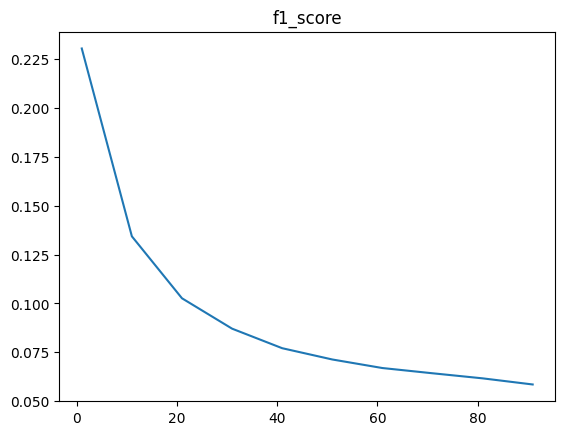

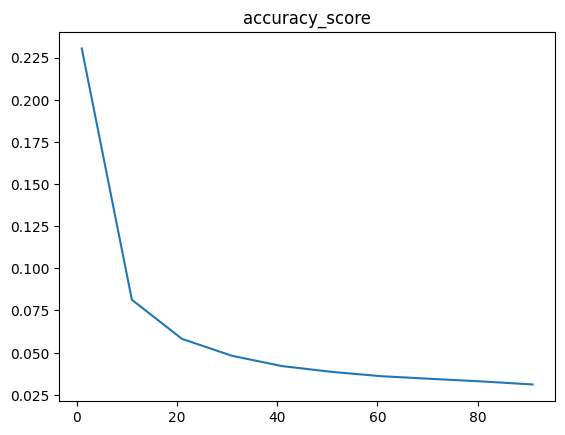

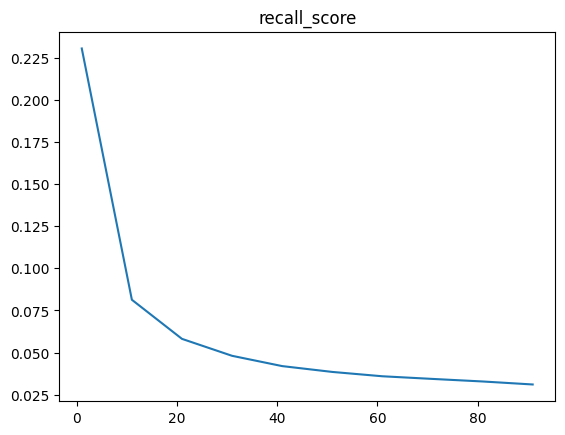

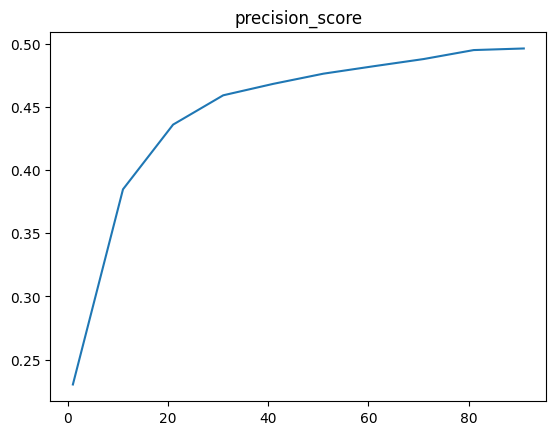

In [ ]:
for score in scoring_lists:
    fig, ax = plt.subplots()
    ax.plot(validation_ks, scoring_lists[score])
    ax.set_title(score)